<a href="https://colab.research.google.com/github/bartheart/lego_detection/blob/main/lego_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from PIL import Image
import seaborn as sns
import tensorflow as tf
#from fastai.vision.all import *
#from fastai.vision.widgets import *
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from time import perf_counter

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/archive/dataset

Mounted at /content/drive
/content/drive/My Drive/archive/dataset


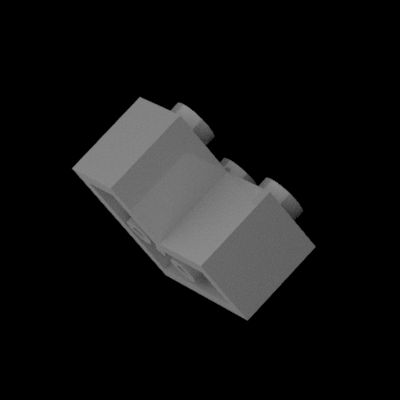

In [6]:
dir_ = Path("/content/drive/My Drive/archive/dataset")
path = "2357 brick corner 1x2x2 019R.png"
brick_image = Image.open(path)
brick_image.resize((200, 200))
brick_image

In [7]:
file_paths = list(dir_.glob(r'**/*.png'))
file_paths = [str(x) for x in file_paths]
df = pd.DataFrame({'Filepath':file_paths})

In [8]:
def get_label(string):
    string = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[1:-1])
    string = string.lower()
    return string

In [9]:
df['Label'] = df['Filepath'].apply(lambda x: get_label(x))
df

,Filepath,Label
0,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2
1,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m
2,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2
3,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2
4,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m
...,...,...
40207,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2
40208,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2
40209,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2
40210,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2


IndexError: index 24 is out of bounds for axis 0 with size 24

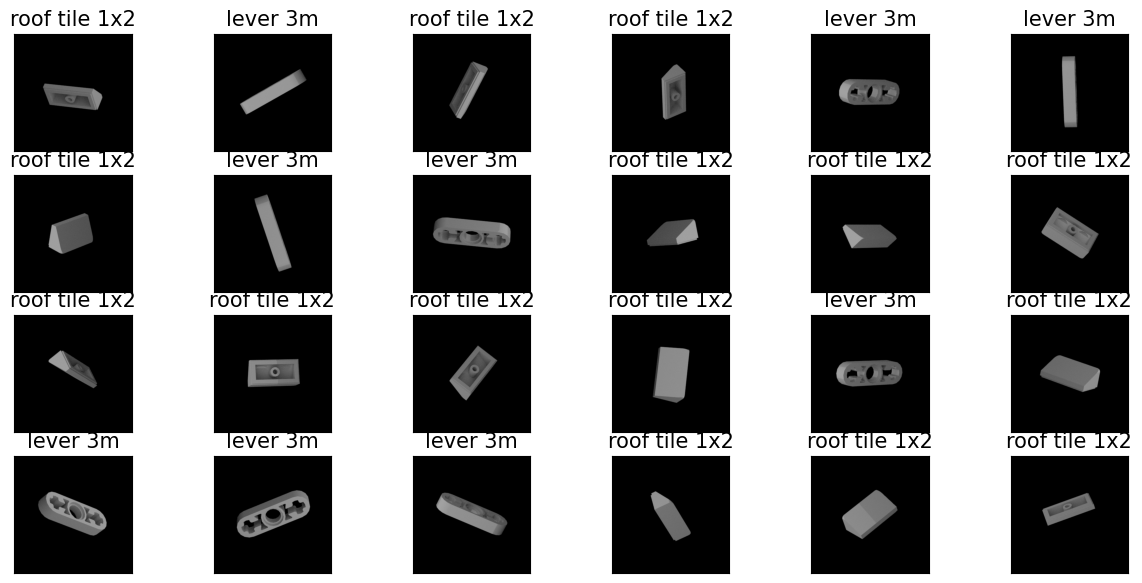

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, row in df.iterrows():
    filepath = row['Filepath']
    if os.path.isfile(filepath):
        ax = axes.flat[i]  # Access the corresponding subplot using index
        ax.imshow(plt.imread(filepath))
        ax.set_title(row['Label'], fontsize=15)
    else:
        ax.text(0.5, 0.5, "Error: File not found", ha='center', va='center', fontsize=12, color='red')

plt.tight_layout(pad=0.5)
plt.show()

<ipython-input-11-5c8b283eabc9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")


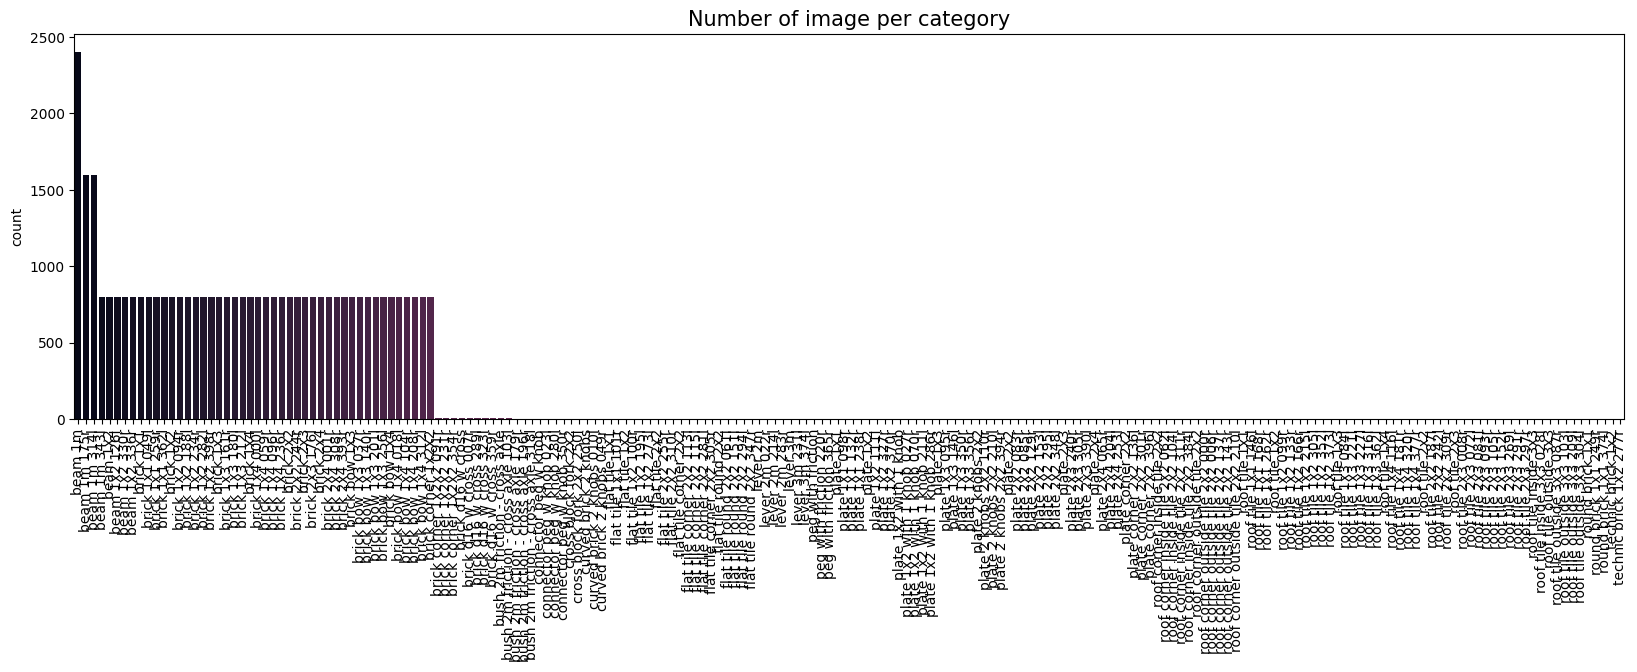

In [11]:
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of image per category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

In [12]:
validation = pd.read_csv('/content/drive/My Drive/archive/validation.txt', names = ['Filepath'])
validation['Filepath'] = validation['Filepath'].apply(lambda x: '/content/drive/My Drive/archive/dataset/' + x)
validation.head()

,Filepath
0,/content/drive/My Drive/archive/dataset/14719 ...
1,/content/drive/My Drive/archive/dataset/14719 ...
2,/content/drive/My Drive/archive/dataset/14719 ...
3,/content/drive/My Drive/archive/dataset/14719 ...
4,/content/drive/My Drive/archive/dataset/14719 ...


In [13]:
df['validation_set'] = df['Filepath'].isin(validation['Filepath'])
df

,Filepath,Label,validation_set
0,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2,False
1,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m,False
2,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2,False
3,/content/drive/My Drive/archive/dataset/85984 ...,roof tile 1x2,True
4,/content/drive/My Drive/archive/dataset/6632 l...,lever 3m,False
...,...,...,...
40207,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False
40208,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False
40209,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False
40210,/content/drive/My Drive/archive/dataset/14719 ...,flat tile corner 2x2,False


In [14]:
train_df = df[df['validation_set'] == False]
test_df = df[df['validation_set'] == True]

In [15]:
print(f'Number of training images: {train_df.shape[0]}')
print(f'Number of testing images: {test_df.shape[0]}')

Number of training images: 32212
Number of testing images: 8000


In [16]:
def create_gen():
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_generator,test_generator,train_images,val_images,test_images

In [17]:
def create_compile_model(model_info, num_classes):

  if 'model' not in model_info:
    model = model_info['model'](**{'input_shape':(None, 224, 224, 3), 'include_top': False, 'weights': 'imagenet'})
    model.trainable = False

    # Print output shape before slicing (for debugging)
    output = model(dummy_input)
    print(f"MobileNetV2 output shape: {output.shape}")

    # Temporarily comment out Dense layers for isolation (optional)
    # x = tf.keras.layers.Dense(128, activation='relu')(model.output)
    # x = tf.keras.layers.Dense(128, activation='relu')(x)
    # outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=model.input, outputs=model.output)  # Use model.output directly for now

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model_info['model'] = model

  return model_info['model']

In [18]:
model_info = {
  'model': tf.keras.applications.MobileNetV2,  # Replace with your pre-trained model
}

# Dummy data (assuming MobileNetV2 input shape)
dummy_input = tf.random.normal(shape=(1, 224, 224, 3)) # Random image data

# Call the function with sample input
compiled_model = create_compile_model(model_info, num_classes=10)  # Assuming 10 classes

# Test the model with dummy input (optional)
try:
  dummy_output = compiled_model(dummy_input)
  print(f"Dummy output shape: {dummy_output.shape}")
except Exception as e:
  print(f"Error testing model: {e}")

Error testing model: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 1 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/


In [19]:
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [20]:
def train_evaluate_models(models, train_df, test_df=None):

  num_classes = len(train_df['Label'].unique())  # Get number of classes from labels

  train_datagen, test_datagen, train_images, val_images, test_images = create_gen()

  for name, model_info in models.items():
    model = create_compile_model(model_info, num_classes)

    start = perf_counter()
    history = model.fit(train_images, validation_data=val_images, epochs=epochs, verbose=1)
    duration = perf_counter() - start
    duration = round(duration, 2)

    model_info['perf'] = duration
    val_acc = history.history['val_accuracy']
    model_info['val_acc'] = [round(v, 4) for v in val_acc]

    print(f"{name:20} trained in {duration} sec")

  return models

In [21]:
trained_models = train_evaluate_models(models, train_df)

Found 28991 validated image filenames belonging to 198 classes.
Found 3221 validated image filenames belonging to 198 classes.
Found 8000 validated image filenames belonging to 46 classes.


AttributeError: 'function' object has no attribute 'fit'